In [20]:
import tensorflow as tf
import numpy as np
import data
import matplotlib.pyplot as plt
from matplotlib.colors import  ListedColormap
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

In [21]:
NUM_EXAMPLES = 10
CLASSES = 3
DISTRIBUTIONS = 6
SEED = 106

In [22]:
class TFDeep:
    """
        Class that represents a deep neural network implementation in tensorflow.
    """

    def __init__(self, shapes, param_delta=0.1, param_lambda=0.01):
        """Arguments:
           - D: dimensions of each datapoint
           - C: number of classes
           - param_delta: training step
        """
        self.X = tf.placeholder(dtype=tf.float32, shape=[None, shapes[0]])
        self.Yoh_ = tf.placeholder(dtype=tf.float32, shape=[None, shapes[-1]])

        self.weights = []
        self.biases = []
        self.hs = []

        for index, shape in enumerate(shapes[1:]):
            self.weights.append(tf.Variable(initial_value=tf.random_normal([shapes[index], shape])))
            self.biases.append(tf.Variable(initial_value=tf.random_normal([1, shape])))

        # NN input
        # self.hs.append(tf.nn.sigmoid(tf.matmul(self.X, self.weights[0]) + self.biases[0]))
        self.hs.append(tf.nn.relu(tf.matmul(self.X, self.weights[0]) + self.biases[0]))

        # NN inner connections
        for i in range(1, len(shapes[1:-1])):
            self.hs.append(tf.nn.relu(tf.matmul(self.hs[-1], self.weights[i]) + self.biases[i]))
            # self.hs.append(tf.nn.sigmoid(tf.matmul(self.hs[-1], self.weights[i]) + self.biases[i]))

        # NN output
        if len(shapes[1:-1]) == 0:
            # regular logistic regression
            output = tf.matmul(self.X, self.weights[-1]) + self.biases[-1]
        else:
            # neural network last layer output
            output = tf.matmul(self.hs[-1], self.weights[-1]) + self.biases[-1]

        self.probs = tf.nn.softmax(output)

        self.cross_entropy = tf.reduce_mean(-tf.reduce_sum(self.Yoh_ * tf.log(self.probs), axis=1))
        self.regularization = [param_lambda * tf.nn.l2_loss(weights) for weights in self.weights]
        self.loss = self.cross_entropy + tf.add_n(self.regularization)

        self.train_step = tf.train.GradientDescentOptimizer(param_delta).minimize(self.loss)

        self.session = tf.InteractiveSession()

    def train(self, X, Yoh_, param_niter):
        """Arguments:
           - X: actual datapoints [NxD]
           - Yoh_: one-hot encoded labels [NxC]
           - param_niter: number of iterations
        """
        self.session.run(tf.initialize_all_variables())

        for i in range(param_niter+1):
            tr = self.session.run([self.train_step], feed_dict={self.X: X, self.Yoh_: Yoh_})
            if i % 1000 == 0:
                loss = self.session.run(self.loss, feed_dict={self.X: X, self.Yoh_: Yoh_})
                print("{0:4}. Loss: {1:.8f}".format(i, loss))

    def eval(self, X):
        """Arguments:
           - X: actual datapoints [NxD]
           Returns: predicted class probabilites [NxC]
        """
        probs = self.session.run(self.probs, feed_dict={self.X: X})
        return probs

    def classify(self, X):
        return np.argmax(self.eval(X), axis=1)

    def eval_perf(self, Y, Y_):
        # needed to compute scores of our model
        # 'weighted' takes into consideration labels imbalance
        if max(int(max(Y_) + 1), int(max(Y) + 1)) == 2:
            average = 'binary'
        else:
            average = 'weighted'

        accuracy = accuracy_score(Y_, Y)
        precision = precision_score(Y_, Y, average=average)
        recall = recall_score(Y_, Y, average=average)
        f1 = f1_score(Y_, Y, average=average)

        print("Accuracy: {0:.3f}\n"
              "Precision: {1:.3f}\n"
              "Recall: {2:.3f}\n"
              "F1: {3:.3f} ".format(accuracy, precision, recall, f1))

In [23]:
np.random.seed(SEED)
tf.set_random_seed(SEED)
X, Y_ = data.sample_gmm_2d(DISTRIBUTIONS, CLASSES, NUM_EXAMPLES)

In [24]:
Yoh_ = Y_.reshape(-1)
Yoh_ = np.eye(CLASSES)[Yoh_]

In [25]:
shape = [2, 10, 15,CLASSES]

tfdeep = TFDeep(shape, param_delta=0.01, param_lambda=0.01)

In [26]:
tfdeep.train(X, Yoh_, 100000)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
   0. Loss: 7.51456070
1000. Loss: 1.20879865
2000. Loss: 1.04534745
3000. Loss: 0.92257541
4000. Loss: 0.81510556
5000. Loss: 0.73217344
6000. Loss: 0.65721190
7000. Loss: 0.60149956
8000. Loss: 0.55563235
9000. Loss: 0.51674169
10000. Loss: 0.47805291
11000. Loss: 0.45004666
12000. Loss: 0.42210463
13000. Loss: 0.40302104
14000. Loss: 0.38772094
15000. Loss: 0.37528145
16000. Loss: 0.36506099
17000. Loss: 0.35665274
18000. Loss: 0.34964567
19000. Loss: 0.34382984
20000. Loss: 0.33898646
21000. Loss: 0.33485371
22000. Loss: 0.33129174
23000. Loss: 0.32825494
24000. Loss: 0.32571483
25000. Loss: 0.32367811
26000. Loss: 0.32187286
27000. Loss: 0.32030869
28000. Loss: 0.31896037
29000. Loss: 0.31780997
30000. Loss: 0.31679118
31000. Loss: 0.31578761
32000. Loss: 0.31506813
33000. Loss: 0.31443822
34000. Loss: 0.31388080
35000. Loss: 0.31334853
36000. Loss: 0.31292933
37000. Loss: 0.31251010
38000. Loss: 0.31218639


In [27]:
probs = tfdeep.eval(X)
print("Predicted:\n", np.argmax(probs, axis=1))
print("True:\n",Y_.flatten())

Predicted:
 [2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 0 2 0 2 2 2 0 2 0 2 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
True:
 [2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]


In [28]:
tfdeep.eval_perf(np.argmax(probs, axis=1), np.argmax(Yoh_, axis=1))

Accuracy: 0.917
Precision: 0.922
Recall: 0.917
F1: 0.916 


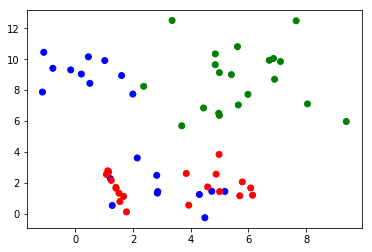

In [29]:
colors = ['red', 'green', 'blue']
plt.scatter(X[:, 0], X[:, 1], c=Y_.flatten(), cmap=ListedColormap(colors))
plt.show()

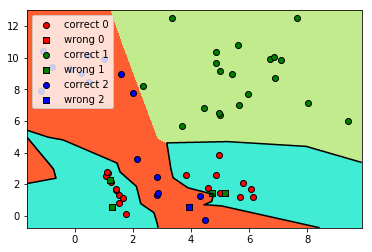

In [30]:
data.plot_decision_boundary(X, lambda x: tfdeep.classify(x))
# graph the data points
data.graph_data(X, Y_, np.argmax(probs, axis=1))

In [31]:
SEED = 105
np.random.seed(SEED)
tf.set_random_seed(SEED)
X2, Y_2 = data.sample_gmm_2d(DISTRIBUTIONS, CLASSES, NUM_EXAMPLES)

In [32]:
Yoh_2 = Y_2.reshape(-1)
Yoh_2 = np.eye(CLASSES)[Yoh_2]

In [33]:
tfdeep2 = TFDeep(shape, param_delta=0.03, param_lambda=0.01)

In [34]:
tfdeep2.train(X2, Yoh_2, 100000)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
   0. Loss: 4.87134075
1000. Loss: nan
2000. Loss: nan
3000. Loss: nan
4000. Loss: nan
5000. Loss: nan
6000. Loss: nan
7000. Loss: nan
8000. Loss: nan
9000. Loss: nan
10000. Loss: nan
11000. Loss: nan
12000. Loss: nan
13000. Loss: nan
14000. Loss: nan
15000. Loss: nan
16000. Loss: nan
17000. Loss: nan
18000. Loss: nan
19000. Loss: nan
20000. Loss: nan
21000. Loss: nan
22000. Loss: nan
23000. Loss: nan
24000. Loss: nan
25000. Loss: nan
26000. Loss: nan
27000. Loss: nan
28000. Loss: nan
29000. Loss: nan
30000. Loss: nan
31000. Loss: nan
32000. Loss: nan
33000. Loss: nan
34000. Loss: nan
35000. Loss: nan
36000. Loss: nan
37000. Loss: nan
38000. Loss: nan
39000. Loss: nan
40000. Loss: nan
41000. Loss: nan
42000. Loss: nan
43000. Loss: nan
44000. Loss: nan
45000. Loss: nan
46000. Loss: nan
47000. Loss: nan
48000. Loss: nan
49000. Loss: nan
50000. Loss: nan
51000. Loss: nan
52000. Loss: nan
53000. Loss: nan
54000. Loss

In [35]:
probs2 = tfdeep2.eval(X2)
print("Predicted:\n", np.argmax(probs2, axis=1))
print("True:\n",Y_2.flatten())

Predicted:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
True:
 [2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [36]:
tfdeep2.eval_perf(np.argmax(probs2, axis=1), np.argmax(Yoh_2, axis=1))

Accuracy: 0.333
Precision: 0.111
Recall: 0.333
F1: 0.167 


/home/dreyus95/Python/tf_environments/tf3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dreyus95/Python/tf_environments/tf3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


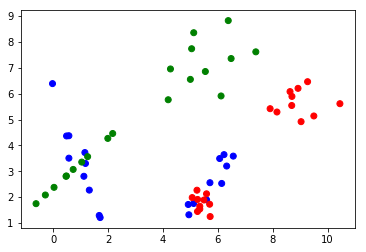

In [37]:
plt.scatter(X2[:, 0], X2[:, 1], c=Y_2.flatten(), cmap=ListedColormap(colors))
plt.show()

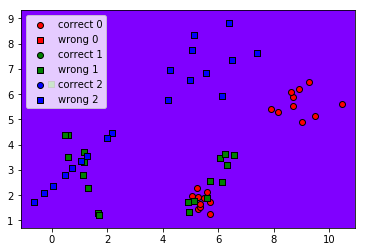

In [38]:
data.plot_decision_boundary(X2, lambda x: tfdeep2.classify(x))
# graph the data points
data.graph_data(X2, Y_2, np.argmax(probs2, axis=1))